## Importing Libraries


In [1]:
import pyautogui
import random
import time

# Get screen size
screen_width, screen_height = pyautogui.size()

try:
    while True:
        # Generate random position within screen bounds
        x = random.randint(0, screen_width - 1)
        y = random.randint(0, screen_height - 1)
        
        # Move mouse to the random position
        pyautogui.moveTo(x, y, duration=0.5)  # Smooth move in 0.5 seconds
        
        print(f"Moved to ({x}, {y})")
        time.sleep(5)

except KeyboardInterrupt:
    print("Mouse mover stopped.")


Moved to (884, 610)
Moved to (1365, 250)
Moved to (593, 423)
Moved to (8, 453)
Moved to (812, 512)
Moved to (36, 140)
Moved to (1565, 87)
Moved to (442, 29)
Moved to (596, 691)
Moved to (1072, 1023)
Moved to (1574, 132)
Moved to (1320, 104)
Moved to (1130, 389)
Moved to (132, 452)
Moved to (661, 80)
Moved to (315, 184)
Moved to (1261, 765)
Moved to (1121, 255)
Moved to (544, 763)
Moved to (623, 93)
Moved to (869, 43)
Moved to (1650, 785)
Moved to (1048, 1077)
Moved to (460, 117)
Moved to (126, 423)
Moved to (92, 849)
Moved to (1443, 1047)
Moved to (314, 371)
Moved to (583, 52)
Moved to (1629, 348)
Moved to (471, 58)
Moved to (1343, 933)
Moved to (630, 715)
Moved to (1095, 995)
Moved to (274, 567)
Moved to (562, 187)
Moved to (829, 760)
Moved to (1763, 264)
Moved to (1882, 166)
Moved to (67, 871)
Moved to (1418, 56)
Moved to (1877, 52)
Moved to (1108, 548)
Moved to (807, 303)
Moved to (1330, 247)
Moved to (1418, 456)
Moved to (340, 625)
Moved to (1034, 771)
Moved to (370, 123)
Moved to 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc,
    mean_squared_error
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

## Training the data

In [ ]:
def train_test_split_data(df, target_col, test_size=0.2, random_state=42):
    
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in the dataset.")
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y if y.nunique() > 1 else None)


## Data Encoding

In [ ]:
def encode_data(df, cat_cols):
    df_copy = df.copy()
    le = LabelEncoder()
    
    for col in cat_cols:
        if col in df_copy.columns:
            df_copy[col] = le.fit_transform(df_copy[col].astype(str))
        else:
            print(f"Warning: Column '{col}' not found in dataset, skipping encoding.")

    return df_copy

## Scaling the Data

In [ ]:
def preprocess_data(df, cat_cols=None, num_cols=None):
    
    df_copy = df.copy()
    
    if cat_cols:
        df_copy = encode_data(df_copy, cat_cols)
    
    if num_cols:
        scaler = StandardScaler()
        df_copy[num_cols] = scaler.fit_transform(df_copy[num_cols])
    
    return df_copy

##  Hyperparameter Fine Tuning

In [ ]:
def tune_hyperparameters(model, param_grid, X_train, y_train, method="grid"):
    
    if method == "grid":
        search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
    elif method == "random":
        search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=5, random_state=42, n_jobs=-1, verbose=1)
    else:
        raise ValueError("Method must be either 'grid' or 'random'.")
    
    search.fit(X_train, y_train)
    print(f"Best Parameters for {model.__class__.__name__}: {search.best_params_}")
    
    return search.best_estimator_

# Model Training and Evaluationg

In [ ]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Naive Bayes': GaussianNB(),
    }
    
    results = []
    trained_models = {}

    for model_name, model in models.items():
        if model_name == "Random Forest":
            param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
            best_model = tune_hyperparameters(model, param_grid, X_train, y_train, method="random")
        elif model_name == "Decision Tree":
            param_grid = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5], 'criterion': ['gini', 'entropy']}
            best_model = tune_hyperparameters(model, param_grid, X_train, y_train, method="grid")
        else:
            best_model = model
        
        best_model.fit(X_train, y_train)
        trained_models[model_name] = best_model
        
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=1)
        
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

    return pd.DataFrame(results), trained_models

## Plotting confusion matrix, ROC curve, and MSE graph

In [ ]:
def plot_graphs(models, X_test, y_test):
    """Plot model evaluation metrics attractively: Accuracy, Confusion Matrices, ROC Curve, and MSE."""
    
    model_names = list(models.keys())
    colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9']  # Custom colors

    # 1. Compute all evaluation metrics
    accuracies = []
    mse_values = []
    fpr_tpr_auc = {}  # Store ROC data  

    plt.figure(figsize=(12, 8))
    for i, (model_name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

        # Compute metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        mse_values.append(mean_squared_error(y_test, y_pred))
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        auc_score = auc(fpr, tpr)
        fpr_tpr_auc[model_name] = (fpr, tpr, auc_score)

    # 2. Accuracy Bar Chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_names, y=accuracies, palette=colors)
    plt.title("Model Accuracy Comparison", fontsize=14, fontweight='bold')
    plt.ylabel("Accuracy Score")
    plt.ylim(0, 1)
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)
    plt.show()

    # 3. ROC Curves in One Graph
    plt.figure(figsize=(10, 6))
    for i, (model_name, (fpr, tpr, auc_score)) in enumerate(fpr_tpr_auc.items()):
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})", color=colors[i])
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title("ROC Curve Comparison", fontsize=14, fontweight='bold')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

    # 4. Confusion Matrices (2x2 Grid)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Confusion Matrices", fontsize=16, fontweight='bold')

    for i, (model_name, model) in enumerate(models.items()):
        if i >= 4:
            break
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        ax = axes[i // 2, i % 2]
        sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False, ax=ax, annot_kws={"size": 16})
        ax.set_title(f"{model_name}", fontsize=12, fontweight='bold')
        ax.set_xlabel("Predicted", fontsize=10)
        ax.set_ylabel("True", fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 5. MSE Comparison Bar Chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_names, y=mse_values, palette=colors)
    plt.title("Mean Squared Error (MSE) Comparison", fontsize=14, fontweight='bold')
    plt.ylabel("MSE Value")
    for i, mse in enumerate(mse_values):
        plt.text(i, mse + 0.02, f"{mse:.2f}", ha='center', fontsize=12)
    plt.show()

## Performance Table

In [ ]:
def create_performance_table(results):
    
    print("Performance Metrics:")
    print(results.to_string(index=False))

## Reading the dataset

In [ ]:
df = pd.read_csv("cleaned_dataset.csv")

In [ ]:

def identify_column_types(df):

    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(exclude=['number']).columns.tolist()

    return {"0": numerical_cols, "1": categorical_cols}


In [ ]:
column_types = identify_column_types(df)
cat_cols = column_types['1']
num_cols = column_types['0']
target_col = "loan_status"


In [ ]:
df_processed = preprocess_data(df, cat_cols, num_cols)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split_data(df_processed, target_col)


In [ ]:
results, trained_models = train_and_evaluate_models(X_train, y_train, X_test, y_test)


In [ ]:
print(results)


In [ ]:
plot_graphs(trained_models, X_test, y_test)


In [ ]:
create_performance_table(results)


In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(trained_models, feature_names, top_n=10):
    for model_name, model in trained_models.items():
        # Tree-based models
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[-top_n:]

            plt.figure(figsize=(10, 6))
            plt.title(f'Top {top_n} Feature Importances - {model_name}')
            plt.barh(range(len(indices)), importances[indices], align='center')
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel('Importance Score')
            plt.tight_layout()
            plt.show()

        # Logistic Regression
        elif model_name == "Logistic Regression" and hasattr(model, "coef_"):
            coefs = model.coef_[0]
            indices = np.argsort(np.abs(coefs))[-top_n:]

            plt.figure(figsize=(10, 6))
            plt.title(f'Top {top_n} Feature Influences - {model_name}')
            plt.barh(range(top_n), coefs[indices], align='center')
            plt.yticks(range(top_n), [feature_names[i] for i in indices])
            plt.xlabel('Coefficient Value')
            plt.axvline(0, color='grey', linestyle='--')
            plt.tight_layout()
            plt.show()

        # Naive Bayes
        elif model_name == "Naive Bayes" and hasattr(model, "feature_log_prob_"):
            log_probs = model.feature_log_prob_
            mean_log_prob = np.mean(log_probs, axis=0)
            indices = np.argsort(mean_log_prob)[-top_n:]

            plt.figure(figsize=(10, 6))
            plt.title(f'Top {top_n} Feature Influences - {model_name}')
            plt.barh(range(top_n), mean_log_prob[indices], align='center')
            plt.yticks(range(top_n), [feature_names[i] for i in indices])
            plt.xlabel('Mean Log Probability')
            plt.tight_layout()
            plt.show()

        else:
            print(f"[Info] Feature importance/influence not available for model: {model_name}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for RandomForestClassifier: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 10}


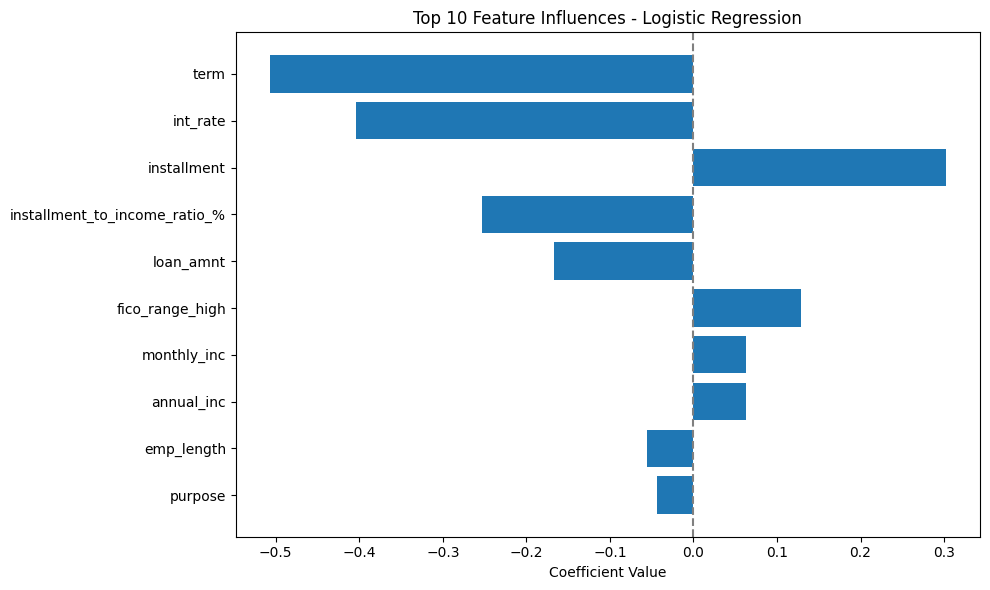

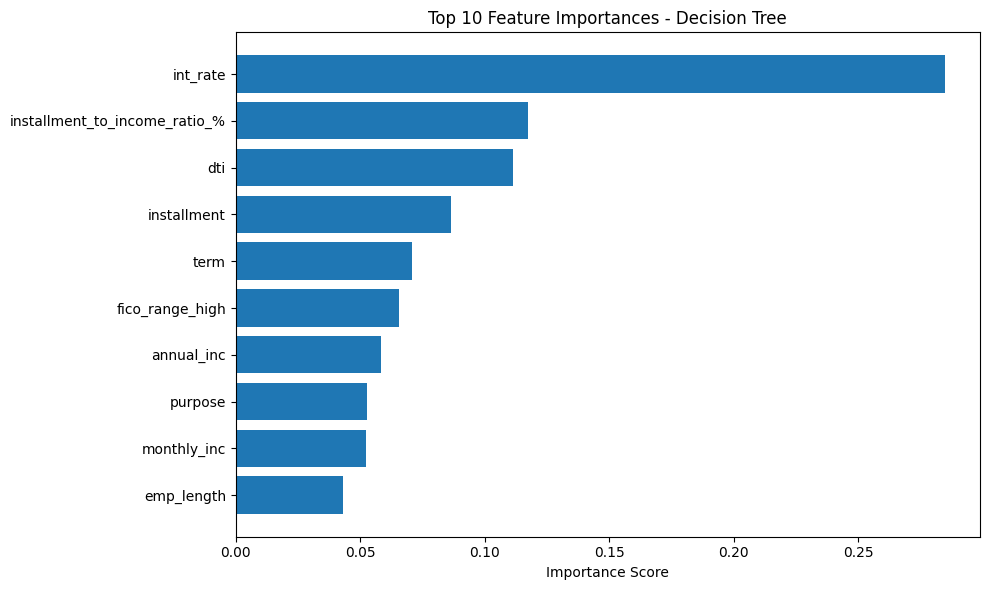

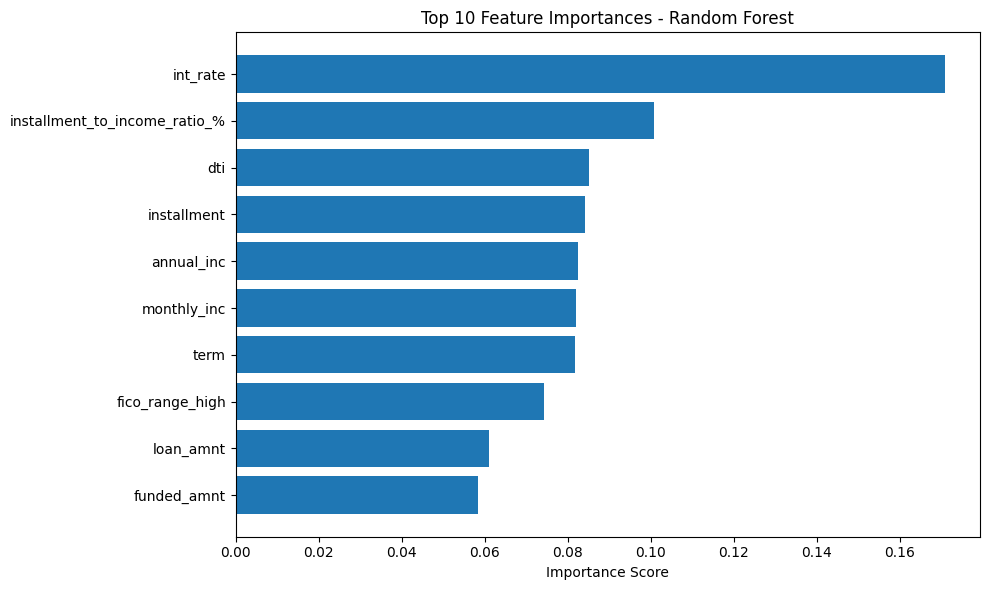

[Info] Feature importance/influence not available for model: Naive Bayes


In [26]:
# After training
results_df, trained_models = train_and_evaluate_models(X_train, y_train, X_test, y_test)

# Feature importance plot
plot_feature_importances(trained_models, feature_names=X_train.columns, top_n=10)
